Created heavily deformed microstructure
  Initial stored energy range: 3.95e+05 - 1.54e+08 J/m³
  Mean KAM: 10.66°, Max KAM: 62.80°

Initial state:
  Grains: 37
  Rex fraction: 0.000
  Mean stored energy: 1.60e+07 J/m³
  Number of low energy cells: 7161

Starting simulation...

Simulation completed:
  Total steps: 411
  Final time: 10.089s
  Final rex fraction: 0.040
  Final number of grains: 28


C:\Users\owner\AppData\Local\Temp\ipykernel_13396\690175482.py:713: UserWarning: tight_layout not applied: number of columns in subplot specifications must be multiples of one another.
  plt.tight_layout()


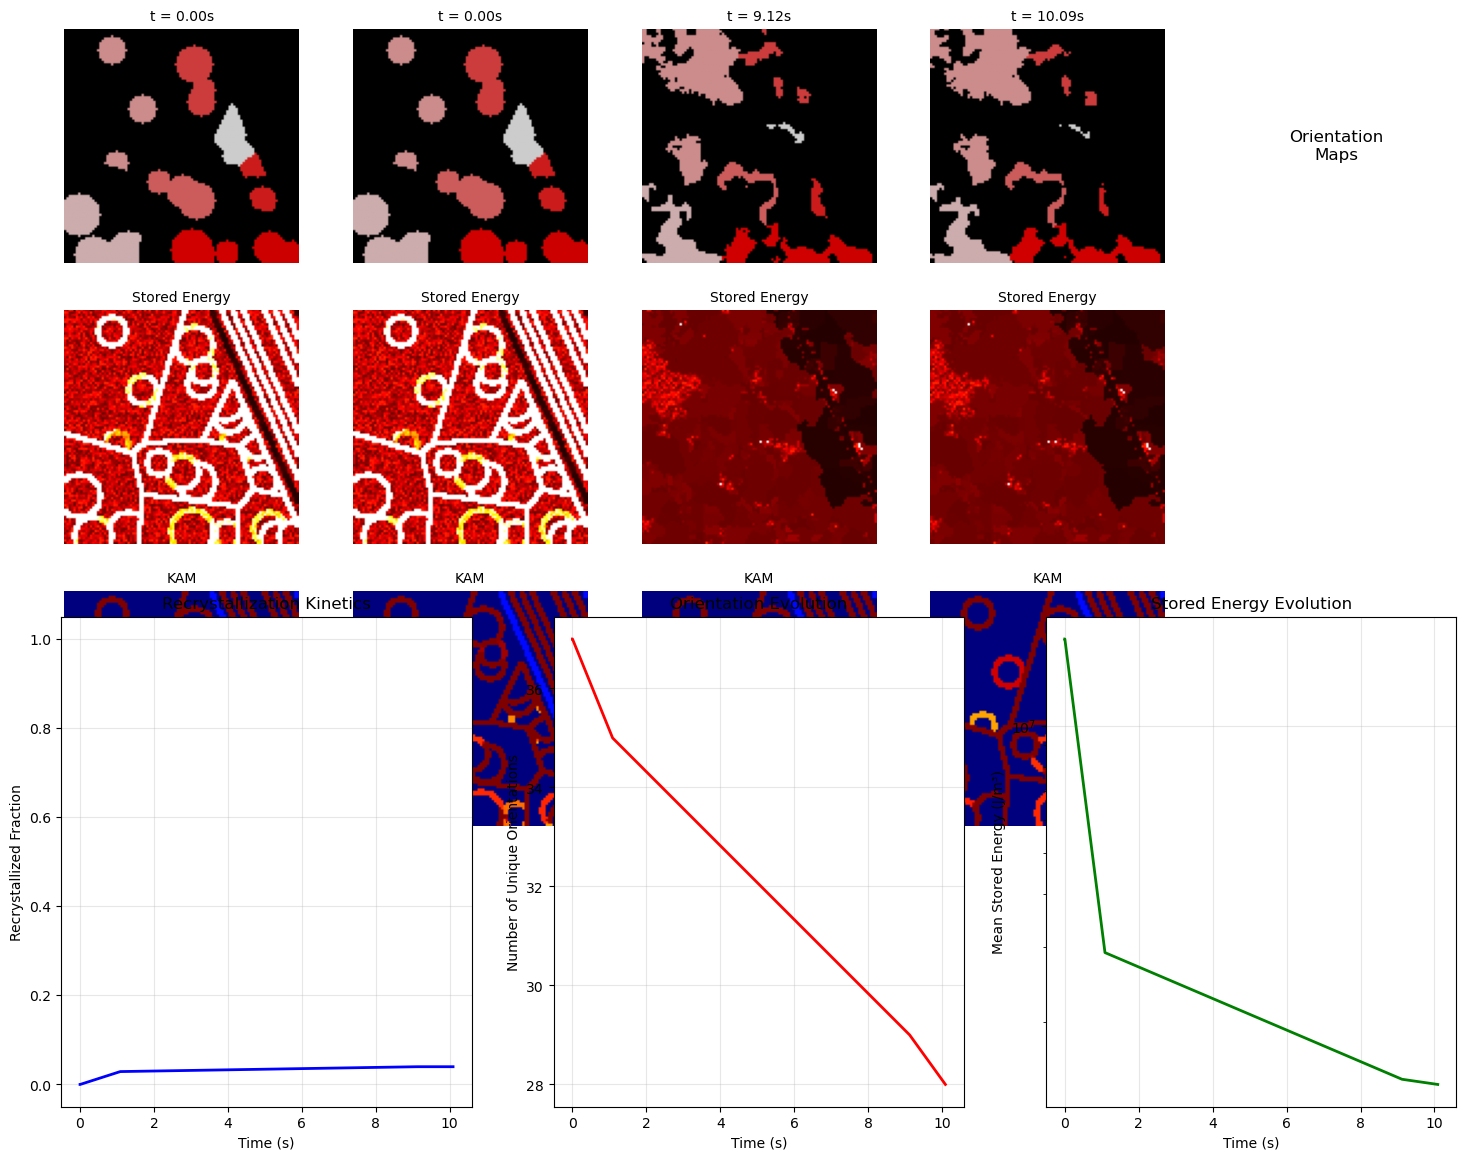

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from dataclasses import dataclass
from typing import List, Tuple, Dict, Set

@dataclass
class CellularAutomatonRexGG:
    """
    Cellular Automaton for Recrystallization and Grain Growth
    Using quaternions for orientation and creating heavily deformed microstructure
    """
    # Grid parameters
    nx: int = 100  # Reduced from 150
    ny: int = 100  # Reduced from 150
    dx: float = 1e-6  # Cell size in meters
    
    # Material parameters
    grain_boundary_energy: float = 0.5  # J/m^2
    mobility_pre_exponential: float = 1e-3  # m^4/(J·s) - increased from 1e-4
    activation_energy: float = 140e3  # J/mol
    temperature: float = 873  # K
    R: float = 8.314  # J/(mol·K)
    
    # Misorientation thresholds
    min_misorientation: float = 1.0   # degrees
    lagb_threshold: float = 2.0       # degrees  
    hagb_threshold: float = 15.0      # degrees
    
    # Stored energy parameters
    stored_energy_factor: float = 1e7  # J/m^3 - increased for heavily deformed state
    max_kam_degrees: float = 15.0       # Increased for severe deformation
    
    # Kinetic factor
    beta_factor: float = 0.5
    
    def __init__(self):
        self.n_cells = self.nx * self.ny
        
        # Microstructure state
        self.orientation_id = np.zeros(self.n_cells, dtype=int)
        self.quaternions = {}  # orientation_id -> quaternion (w, x, y, z)
        
        # Deformation state
        self.kam = np.zeros(self.n_cells)
        self.stored_energy = np.zeros(self.n_cells)
        
        # Cellular automaton state
        self.consumption_rate = np.zeros(self.n_cells)
        self.consumed_fraction = np.zeros(self.n_cells)
        self.growing_neighbor = -np.ones(self.n_cells, dtype=int)
        
        # Tracking
        self.boundary_cells = set()
        self.is_recrystallized = np.zeros(self.n_cells, dtype=bool)
        
        # Cache for misorientation calculations
        self._misorientation_cache = {}
        
        # Statistics tracking
        self.total_time = 0.0
        self.step_count = 0
        
        # Initialize heavily deformed microstructure
        self._create_heavily_deformed_microstructure()
        self._identify_boundary_cells()
    
    def euler_to_quaternion(self, phi1, Phi, phi2):
        """Convert Euler angles (degrees) to quaternion"""
        # Convert to radians
        phi1 = np.radians(phi1)
        Phi = np.radians(Phi)
        phi2 = np.radians(phi2)
        
        # Calculate quaternion components
        c1 = np.cos(phi1/2)
        c2 = np.cos(Phi/2)
        c3 = np.cos(phi2/2)
        s1 = np.sin(phi1/2)
        s2 = np.sin(Phi/2)
        s3 = np.sin(phi2/2)
        
        w = c1*c2*c3 + s1*s2*s3
        x = c1*c2*s3 - s1*s2*c3
        y = c1*s2*c3 + s1*c2*s3
        z = s1*c2*c3 - c1*s2*s3
        
        # Normalize
        norm = np.sqrt(w*w + x*x + y*y + z*z)
        return (w/norm, x/norm, y/norm, z/norm)
    
    def quaternion_multiply(self, q1, q2):
        """Multiply two quaternions"""
        w1, x1, y1, z1 = q1
        w2, x2, y2, z2 = q2
        
        w = w1*w2 - x1*x2 - y1*y2 - z1*z2
        x = w1*x2 + x1*w2 + y1*z2 - z1*y2
        y = w1*y2 - x1*z2 + y1*w2 + z1*x2
        z = w1*z2 + x1*y2 - y1*x2 + z1*w2
        
        return (w, x, y, z)
    
    def quaternion_conjugate(self, q):
        """Get conjugate of quaternion"""
        w, x, y, z = q
        return (w, -x, -y, -z)
    
    def _create_heavily_deformed_microstructure(self):
        """Create a heavily deformed microstructure with severe orientation gradients"""
        
        # Create initial grain structure with fewer, larger grains
        n_grains = 8
        grain_centers = np.random.rand(n_grains, 2)
        grain_centers[:, 0] *= self.nx
        grain_centers[:, 1] *= self.ny
        
        # Assign cells to grains
        for i in range(self.nx):
            for j in range(self.ny):
                cell_idx = i * self.ny + j
                
                # Find nearest grain center
                min_dist = float('inf')
                nearest_grain = 0
                
                for g in range(n_grains):
                    dx = i - grain_centers[g, 0]
                    dy = j - grain_centers[g, 1]
                    dist = dx*dx + dy*dy
                    
                    if dist < min_dist:
                        min_dist = dist
                        nearest_grain = g
                
                self.orientation_id[cell_idx] = nearest_grain
        
        # Generate base orientations using quaternions
        for g in range(n_grains):
            phi1 = np.random.uniform(0, 360)
            Phi = np.random.uniform(0, 180)
            phi2 = np.random.uniform(0, 360)
            self.quaternions[g] = self.euler_to_quaternion(phi1, Phi, phi2)
        
        # Add severe deformation structure
        self._add_deformation_structure(n_grains)
        
        # Calculate KAM
        self._calculate_kam()
        
        # Set stored energy based on severe deformation
        self._set_deformation_energy()
        
        print(f"Created heavily deformed microstructure")
        print(f"  Initial stored energy range: {np.min(self.stored_energy):.2e} - {np.max(self.stored_energy):.2e} J/m³")
        print(f"  Mean KAM: {np.mean(self.kam):.2f}°, Max KAM: {np.max(self.kam):.2f}°")
    
    def _add_deformation_structure(self, n_grains):
        """Add severe deformation with orientation gradients and subgrains"""
        ori_id_offset = n_grains
        
        # Create deformation bands across the sample
        for band_idx in range(3):
            # Band direction and position
            band_angle = np.random.uniform(0, np.pi)
            band_pos = np.random.uniform(0.2, 0.8)
            band_width = np.random.uniform(15, 25)
            
            for i in range(self.nx):
                for j in range(self.ny):
                    # Distance from band center
                    proj = i * np.cos(band_angle) + j * np.sin(band_angle)
                    dist_from_band = abs(proj - band_pos * self.nx)
                    
                    if dist_from_band < band_width:
                        cell_idx = i * self.ny + j
                        parent_ori = self.orientation_id[cell_idx]
                        
                        # Create orientation gradient within band
                        gradient_factor = dist_from_band / band_width
                        
                        # Share orientation among cells in the band
                        band_ori_id = ori_id_offset + band_idx * 10 + int(gradient_factor * 5)
                        
                        if band_ori_id not in self.quaternions:
                            # Create rotation quaternion
                            rotation_angle = (1 - gradient_factor) * np.radians(30)
                            axis = np.random.randn(3)
                            axis = axis / np.linalg.norm(axis)
                            rotation_quat = (
                                np.cos(rotation_angle/2),
                                axis[0] * np.sin(rotation_angle/2),
                                axis[1] * np.sin(rotation_angle/2),
                                axis[2] * np.sin(rotation_angle/2)
                            )
                            
                            # Apply rotation to parent orientation
                            parent_quat = self.quaternions.get(parent_ori, (1, 0, 0, 0))
                            self.quaternions[band_ori_id] = self.quaternion_multiply(rotation_quat, parent_quat)
                        
                        self.orientation_id[cell_idx] = band_ori_id
        
        # Add subgrain structure with cell blocks
        for g in range(n_grains):
            grain_cells = np.where(self.orientation_id == g)[0]
            
            if len(grain_cells) < 20:
                continue
            
            # Create cell blocks (recovered subgrains)
            n_blocks = min(3, len(grain_cells) // 50)
            
            for block in range(n_blocks):
                # Random cell block position
                if len(grain_cells) > 0:
                    center_idx = np.random.choice(grain_cells)
                    center_i, center_j = center_idx // self.ny, center_idx % self.ny
                    
                    # Cell block has low misorientation
                    block_ori_id = ori_id_offset + 10000 + g * 100 + block
                    parent_quat = self.quaternions[g]
                    
                    # Larger rotation for cell block to ensure HAGB
                    small_angle = np.radians(np.random.uniform(10, 20))
                    axis = np.random.randn(3)
                    axis = axis / np.linalg.norm(axis)
                    small_rotation = (
                        np.cos(small_angle/2),
                        axis[0] * np.sin(small_angle/2),
                        axis[1] * np.sin(small_angle/2),
                        axis[2] * np.sin(small_angle/2)
                    )
                    
                    self.quaternions[block_ori_id] = self.quaternion_multiply(small_rotation, parent_quat)
                    
                    # Assign cells to block
                    block_size = np.random.randint(5, 10)
                    for di in range(-block_size, block_size + 1):
                        for dj in range(-block_size, block_size + 1):
                            ni = center_i + di
                            nj = center_j + dj
                            if 0 <= ni < self.nx and 0 <= nj < self.ny:
                                if di*di + dj*dj <= block_size*block_size:
                                    cell_idx = ni * self.ny + nj
                                    if self.orientation_id[cell_idx] == g:
                                        self.orientation_id[cell_idx] = block_ori_id
    
    def _calculate_misorientation_quaternion(self, ori_id1: int, ori_id2: int) -> float:
        """Calculate misorientation between two orientations using quaternions with caching"""
        if ori_id1 == ori_id2:
            return 0.0
        
        # Check cache
        key = (min(ori_id1, ori_id2), max(ori_id1, ori_id2))
        if key in self._misorientation_cache:
            return self._misorientation_cache[key]
        
        q1 = self.quaternions.get(ori_id1, (1, 0, 0, 0))
        q2 = self.quaternions.get(ori_id2, (1, 0, 0, 0))
        
        # Calculate misorientation quaternion: q_mis = q1^(-1) * q2
        q1_conj = self.quaternion_conjugate(q1)
        q_mis = self.quaternion_multiply(q1_conj, q2)
        
        # Extract misorientation angle
        w = min(max(q_mis[0], -1.0), 1.0)  # Clamp to avoid numerical errors
        angle_rad = 2.0 * np.arccos(abs(w))
        angle_deg = np.degrees(angle_rad)
        
        # Apply crystal symmetry (simplified - for cubic symmetry)
        result = min(angle_deg, 62.8)
        
        # Cache result
        self._misorientation_cache[key] = result
        return result
    
    def _calculate_kam(self):
        """Calculate Kernel Average Misorientation for each cell"""
        for cell_idx in range(self.n_cells):
            neighbors = self._get_all_neighbors(cell_idx)
            
            if len(neighbors) == 0:
                self.kam[cell_idx] = 0.0
                continue
            
            total_misorientation = 0.0
            n_boundaries = 0
            
            for nbr in neighbors:
                mis = self._calculate_misorientation_quaternion(
                    self.orientation_id[cell_idx],
                    self.orientation_id[nbr]
                )
                
                if mis > self.min_misorientation:
                    total_misorientation += mis
                    n_boundaries += 1
            
            if n_boundaries > 0:
                self.kam[cell_idx] = total_misorientation / n_boundaries
            else:
                self.kam[cell_idx] = 0.0
    
    def _set_deformation_energy(self):
        """Set stored energy based on severe deformation patterns"""
        # Base stored energy from KAM
        for cell_idx in range(self.n_cells):
            # Exponential relationship with KAM for severe deformation
            normalized_kam = self.kam[cell_idx] / self.max_kam_degrees
            self.stored_energy[cell_idx] = self.stored_energy_factor * (normalized_kam ** 1.5)
        
        # Add additional energy variations
        for i in range(self.nx):
            for j in range(self.ny):
                cell_idx = i * self.ny + j
                
                # Shear band pattern - high stored energy
                shear_band = np.sin(2 * np.pi * (i + j) / (self.nx * 0.3))
                if shear_band > 0.5:
                    self.stored_energy[cell_idx] *= 1.5
                
                # Random variations
                self.stored_energy[cell_idx] *= np.random.uniform(0.8, 1.2)
        
        # Some cells/subgrains have naturally low energy (potential nuclei)
        # These represent cell blocks or recovered regions
        mean_energy = np.mean(self.stored_energy)
        low_energy_cells = np.where(self.kam < 2.0)[0]  # Low KAM regions
        
        for cell_idx in low_energy_cells:
            # These cells have undergone recovery
            self.stored_energy[cell_idx] = np.random.uniform(0.1, 0.3) * mean_energy
    
    def _identify_boundary_cells(self):
        """Identify cells at boundaries"""
        self.boundary_cells.clear()
        
        for cell_idx in range(self.n_cells):
            neighbors = self._get_neighbors(cell_idx)
            
            for nbr in neighbors:
                if self.orientation_id[cell_idx] != self.orientation_id[nbr]:
                    mis = self._calculate_misorientation_quaternion(
                        self.orientation_id[cell_idx],
                        self.orientation_id[nbr]
                    )
                    if mis > self.min_misorientation:
                        self.boundary_cells.add(cell_idx)
                        break
    
    def _get_neighbors(self, cell_idx: int) -> List[int]:
        """Get Von Neumann neighbors (4-connectivity)"""
        i, j = cell_idx // self.ny, cell_idx % self.ny
        neighbors = []
        
        for di, dj in [(-1, 0), (1, 0), (0, -1), (0, 1)]:
            ni = i + di
            nj = j + dj
            if 0 <= ni < self.nx and 0 <= nj < self.ny:
                neighbors.append(ni * self.ny + nj)
        
        return neighbors
    
    def _get_all_neighbors(self, cell_idx: int) -> List[int]:
        """Get Moore neighbors (8-connectivity)"""
        i, j = cell_idx // self.ny, cell_idx % self.ny
        neighbors = []
        
        for di in [-1, 0, 1]:
            for dj in [-1, 0, 1]:
                if di == 0 and dj == 0:
                    continue
                ni = i + di
                nj = j + dj
                if 0 <= ni < self.nx and 0 <= nj < self.ny:
                    neighbors.append(ni * self.ny + nj)
        
        return neighbors
    
    def _get_boundary_energy(self, misorientation: float) -> float:
        """Read-Shockley model for boundary energy"""
        if misorientation < self.min_misorientation:
            return 0.0
        
        if misorientation >= self.hagb_threshold:
            return self.grain_boundary_energy
        
        # Read-Shockley equation
        theta_m = self.hagb_threshold * np.pi / 180
        theta = misorientation * np.pi / 180
        
        return self.grain_boundary_energy * (theta / theta_m) * (1 - np.log(theta / theta_m))
    
    def _get_mobility(self, misorientation: float) -> float:
        """Get boundary mobility with misorientation dependence"""
        if misorientation < self.min_misorientation:
            return 0.0
        
        # Base mobility with Arrhenius temperature dependence
        M0 = self.mobility_pre_exponential * np.exp(-self.activation_energy / (self.R * self.temperature))
        
        if misorientation >= self.hagb_threshold:
            return M0
        else:
            # Strongly reduced mobility for low angle boundaries
            # But not too strongly to allow some growth
            return M0 * (misorientation / self.hagb_threshold) ** 2
    
    def calculate_reorientation_rates(self) -> float:
        """Calculate growth rates based on energy minimization"""
        max_rate = 0.0
        mean_stored_energy = np.mean(self.stored_energy)
        
        # Reset
        self.consumption_rate.fill(0.0)
        self.growing_neighbor.fill(-1)
        
        for cell_idx in self.boundary_cells:
            current_ori = self.orientation_id[cell_idx]
            
            # Calculate current cell's boundary energy per unit area
            current_boundary_energy = 0.0
            for nbr in self._get_all_neighbors(cell_idx):
                mis = self._calculate_misorientation_quaternion(current_ori, self.orientation_id[nbr])
                current_boundary_energy += self._get_boundary_energy(mis)
            
            # Normalize boundary energy by number of neighbors
            current_boundary_energy /= len(self._get_all_neighbors(cell_idx))
            
            # Total energy density (J/m³) - stored energy is already in J/m³
            current_total_energy = current_boundary_energy / self.dx + self.stored_energy[cell_idx]
            
            best_rate = 0.0
            best_neighbor = -1
            
            # Try each neighbor's orientation
            neighbors = self._get_neighbors(cell_idx)
            
            for nbr_idx in neighbors:
                nbr_ori = self.orientation_id[nbr_idx]
                if nbr_ori == current_ori:
                    continue
                
                # Calculate energy if this cell adopts neighbor's orientation
                new_boundary_energy = 0.0
                for other_nbr in self._get_all_neighbors(cell_idx):
                    mis = self._calculate_misorientation_quaternion(nbr_ori, self.orientation_id[other_nbr])
                    new_boundary_energy += self._get_boundary_energy(mis)
                
                # Normalize
                new_boundary_energy /= len(self._get_all_neighbors(cell_idx))
                
                # New total energy density
                new_total_energy = new_boundary_energy / self.dx + self.stored_energy[nbr_idx]
                
                # Energy decrease is the driving force (J/m³)
                energy_decrease = current_total_energy - new_total_energy
                
                # Growth advantage for low stored energy regions (recovered/recrystallized)
                if self.stored_energy[nbr_idx] < 0.3 * mean_stored_energy:
                    # These are recovered regions - give them kinetic advantage
                    energy_decrease = max(energy_decrease, self.stored_energy[cell_idx] * 0.5)
                
                # Only proceed if energy decreases
                if energy_decrease <= 0:
                    continue
                
                # Get mobility of the boundary
                boundary_mis = self._calculate_misorientation_quaternion(current_ori, nbr_ori)
                mobility = self._get_mobility(boundary_mis)
                
                # Rate proportional to mobility and driving pressure
                # v = M * P, where P is in J/m³ (pressure)
                velocity = mobility * energy_decrease
                rate = velocity / self.dx * self.beta_factor
                
                if rate > best_rate:
                    best_rate = rate
                    best_neighbor = nbr_idx
            
            self.consumption_rate[cell_idx] = best_rate
            self.growing_neighbor[cell_idx] = best_neighbor
            max_rate = max(max_rate, best_rate)
        
        return max_rate
    
    def update_microstructure(self, dt: float) -> int:
        """Update cells based on consumption"""
        cells_to_switch = []
        
        # Update consumed fractions
        for cell_idx in self.boundary_cells:
            if self.consumption_rate[cell_idx] > 0:
                self.consumed_fraction[cell_idx] += self.consumption_rate[cell_idx] * dt
                
                if self.consumed_fraction[cell_idx] >= 1.0:
                    cells_to_switch.append(cell_idx)
        
        # Switch cells
        n_switched = 0
        for cell_idx in cells_to_switch:
            nbr_idx = int(self.growing_neighbor[cell_idx])
            if nbr_idx >= 0:
                # Copy orientation
                self.orientation_id[cell_idx] = self.orientation_id[nbr_idx]
                
                # Update stored energy
                self.stored_energy[cell_idx] = self.stored_energy[nbr_idx]
                
                # Track recrystallization
                # A cell is recrystallized if its stored energy is very low
                energy_threshold = 0.2 * np.mean(self.stored_energy)
                if self.stored_energy[cell_idx] < energy_threshold:
                    self.is_recrystallized[cell_idx] = True
                
                # Reset
                self.consumed_fraction[cell_idx] = 0.0
                n_switched += 1
        
        # Update boundaries
        if n_switched > 0:
            self._identify_boundary_cells()
            # Update KAM very rarely (expensive operation)
            if self.step_count % 1000 == 0:
                self._calculate_kam()
        
        return n_switched
    
    def simulate_step(self) -> Tuple[float, int]:
        """Perform one simulation step"""
        max_rate = self.calculate_reorientation_rates()
        
        if max_rate < 1e-15:
            return 0.0, 0
        
        # Adaptive time step
        dt = min(0.5 / max_rate, 1.0)
        
        n_switched = self.update_microstructure(dt)
        
        self.total_time += dt
        self.step_count += 1
        
        return dt, n_switched
    
    def get_statistics(self) -> Dict:
        """Get simulation statistics"""
        unique_oris = len(np.unique(self.orientation_id))
        rex_fraction = np.mean(self.is_recrystallized)
        mean_stored_energy = np.mean(self.stored_energy)
        mean_kam = np.mean(self.kam)
        
        return {
            'n_orientations': unique_oris,
            'rex_fraction': rex_fraction,
            'mean_stored_energy': mean_stored_energy,
            'mean_kam': mean_kam,
            'n_boundaries': len(self.boundary_cells),
            'time': self.total_time
        }

def run_simulation(max_time: float = 20.0, save_interval: int = 100):  # Reduced max_time
    """Run the simulation"""
    ca = CellularAutomatonRexGG()
    
    # History tracking
    history = {
        'time': [],
        'rex_fraction': [],
        'n_orientations': [],
        'mean_kam': [],
        'mean_stored_energy': [],
        'microstructure': [],
        'stored_energy_map': [],
        'kam_map': []
    }
    
    # Store initial state
    stats = ca.get_statistics()
    history['time'].append(0.0)
    history['rex_fraction'].append(stats['rex_fraction'])
    history['n_orientations'].append(stats['n_orientations'])
    history['mean_kam'].append(stats['mean_kam'])
    history['mean_stored_energy'].append(stats['mean_stored_energy'])
    history['microstructure'].append(ca.orientation_id.reshape(ca.nx, ca.ny).copy())
    history['stored_energy_map'].append(ca.stored_energy.reshape(ca.nx, ca.ny).copy())
    history['kam_map'].append(ca.kam.reshape(ca.nx, ca.ny).copy())
    
    print(f"\nInitial state:")
    print(f"  Grains: {stats['n_orientations']}")
    print(f"  Rex fraction: {stats['rex_fraction']:.3f}")
    print(f"  Mean stored energy: {stats['mean_stored_energy']:.2e} J/m³")
    print(f"  Number of low energy cells: {np.sum(ca.stored_energy < 0.5 * np.mean(ca.stored_energy))}")
    print(f"\nStarting simulation...")
    
    # Run simulation
    step = 0
    last_save_step = 0
    no_progress_counter = 0
    last_rex_fraction = stats['rex_fraction']
    
    while ca.total_time < max_time and step < 50000:
        dt, n_switched = ca.simulate_step()
        
        if dt == 0:
            print("\nSteady state reached")
            break
        
        step += 1
        
        # Save history at intervals
        if step - last_save_step >= save_interval or step == 1:
            stats = ca.get_statistics()
            history['time'].append(ca.total_time)
            history['rex_fraction'].append(stats['rex_fraction'])
            history['n_orientations'].append(stats['n_orientations'])
            history['mean_kam'].append(stats['mean_kam'])
            history['mean_stored_energy'].append(stats['mean_stored_energy'])
            history['microstructure'].append(ca.orientation_id.reshape(ca.nx, ca.ny).copy())
            history['stored_energy_map'].append(ca.stored_energy.reshape(ca.nx, ca.ny).copy())
            history['kam_map'].append(ca.kam.reshape(ca.nx, ca.ny).copy())
            
            if step % 500 == 0:
                print(f"Step {step}: t={ca.total_time:.3f}s, "
                      f"Rex={stats['rex_fraction']:.3f}, "
                      f"Grains={stats['n_orientations']}, "
                      f"Mean E={stats['mean_stored_energy']:.2e}")
            
            last_save_step = step
    
    # Save final state
    stats = ca.get_statistics()
    history['time'].append(ca.total_time)
    history['rex_fraction'].append(stats['rex_fraction'])
    history['n_orientations'].append(stats['n_orientations'])
    history['mean_kam'].append(stats['mean_kam'])
    history['mean_stored_energy'].append(stats['mean_stored_energy'])
    history['microstructure'].append(ca.orientation_id.reshape(ca.nx, ca.ny).copy())
    history['stored_energy_map'].append(ca.stored_energy.reshape(ca.nx, ca.ny).copy())
    history['kam_map'].append(ca.kam.reshape(ca.nx, ca.ny).copy())
    
    print(f"\nSimulation completed:")
    print(f"  Total steps: {step}")
    print(f"  Final time: {ca.total_time:.3f}s")
    print(f"  Final rex fraction: {stats['rex_fraction']:.3f}")
    print(f"  Final number of grains: {stats['n_orientations']}")
    
    return ca, history

def visualize_results(ca, history):
    """Enhanced visualization of results"""
    fig = plt.figure(figsize=(18, 14))
    
    # Select time points to show
    n_snapshots = len(history['microstructure'])
    if n_snapshots >= 4:
        indices = [0, n_snapshots//3, 2*n_snapshots//3, n_snapshots-1]
    else:
        indices = list(range(n_snapshots))
    
    # Row 1: Microstructure evolution
    for i, idx in enumerate(indices):
        ax = plt.subplot(4, 5, i+1)
        im = ax.imshow(history['microstructure'][idx], cmap='nipy_spectral')
        ax.set_title(f"t = {history['time'][idx]:.2f}s", fontsize=10)
        ax.axis('off')
    
    # Row 2: Stored energy evolution
    vmax = ca.stored_energy_factor
    for i, idx in enumerate(indices):
        ax = plt.subplot(4, 5, i+6)
        im = ax.imshow(history['stored_energy_map'][idx], cmap='hot', vmin=0, vmax=vmax)
        ax.set_title(f"Stored Energy", fontsize=10)
        ax.axis('off')
    
    # Row 3: KAM evolution
    for i, idx in enumerate(indices):
        ax = plt.subplot(4, 5, i+11)
        im = ax.imshow(history['kam_map'][idx], cmap='jet', vmin=0, vmax=ca.max_kam_degrees)
        ax.set_title(f"KAM", fontsize=10)
        ax.axis('off')
    
    # Add colorbars
    ax = plt.subplot(4, 5, 5)
    ax.axis('off')
    ax.text(0.5, 0.5, 'Orientation\nMaps', ha='center', va='center', fontsize=12)
    
    # Kinetics plots
    # Recrystallization kinetics
    ax = plt.subplot(2, 3, 4)
    ax.plot(history['time'], history['rex_fraction'], 'b-', linewidth=2)
    ax.set_xlabel('Time (s)')
    ax.set_ylabel('Recrystallized Fraction')
    ax.set_title('Recrystallization Kinetics')
    ax.grid(True, alpha=0.3)
    ax.set_ylim(-0.05, 1.05)
    
    # Grain count evolution
    ax = plt.subplot(2, 3, 5)
    ax.plot(history['time'], history['n_orientations'], 'r-', linewidth=2)
    ax.set_xlabel('Time (s)')
    ax.set_ylabel('Number of Unique Orientations')
    ax.set_title('Orientation Evolution')
    ax.grid(True, alpha=0.3)
    
    # Stored energy evolution
    ax = plt.subplot(2, 3, 6)
    ax.semilogy(history['time'], history['mean_stored_energy'], 'g-', linewidth=2)
    ax.set_xlabel('Time (s)')
    ax.set_ylabel('Mean Stored Energy (J/m³)')
    ax.set_title('Stored Energy Evolution')
    ax.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()

if __name__ == "__main__":
    # Run simulation
    ca, history = run_simulation(max_time=10.0, save_interval=200)
    visualize_results(ca, history)